## Install required packages

In [ ]:
from IPython import display

In [ ]:
!pip install transformers
!pip install sentencepiece

display.clear_output()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 54.6 MB/s 
     |████████████████████████████████| 120 kB 72.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.0 MB/s 


AttributeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import required libraries

In [ ]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

## load training data


In [ ]:
train_file_name = r'/content/drive/MyDrive/LP/corpus/total_beauty_translated_1_97602.xlsx'

train_df = pd.read_excel(train_file_name)

In [ ]:
train_df.sample(10)

,stretching hair arrangement | arrange the hair,I want to arrange the hair that is stretching hair arrangement!
86591,transparent grayish color | foreigner-like sof...,A foreigner-like soft bob with curly hair-like...
32785,applied by balance | incorporated without fail...,The hairdresser decides how much the angle is ...
69021,donut loosely braided | ring donut loosely | l...,Put a donut round of the donut in the roots of...
94499,bright high tone | high tone color | low light...,While using a bright high tone color as a base...
79796,bunch when cut | casual styling | sense of mat...,If you have long hair that feels like a bunch ...
56764,simple self-care Concerns | perm with illustra...,Keep your hair straight with simple self-care ...
54081,Uza Bang | Marron beige color | color will giv...,Marron beige color will give you a soft and li...
12097,strong spiral perm | Dramatic long | cheek line,Dramatic long with a strong spiral perm from t...
63037,hair color Smooth | make fashionable hair | re...,Popular colors from darkness and check from da...
40807,order to moisturize | moisturize the hair | ha...,In order to moisturize the hair firmly if the ...


In [ ]:
train_df['prefix'] = "generate"

In [ ]:
train_df.sample(10)

,stretching hair arrangement | arrange the hair,I want to arrange the hair that is stretching hair arrangement!,prefix
6870,attention to lifestyle | care of hair | hair q...,Let's take care of hair quality while paying a...,generate
88946,Bang Long Healthy | Kakiage Bang Long | Kakiag...,Kakiage Bang Long Healthy long hair with Kakia...,generate
95375,boy hairstyle feature | high school boy | hair...,Become a new me with a hair change Hairstyle 2...,generate
68177,favorite style.Please | curly hair | loose atm...,Whether you enjoy it roughly with a curly hair...,generate
22713,wear bright hair | bright hair color | hair co...,Recommended for those who can't wear bright ha...,generate
37278,soft impression | short hair | root to make | ...,"Wavy hair, soft impression, short hair and wav...",generate
11142,Hair arrangement essential | essential hair ay...,Hair arrangement essential hair aylon such as ...,generate
2083,laughs | lifetime | thought | wanted | hairstyle,I thought it was gone and I wanted to have thi...,generate
5279,small hair ornaments | bring a lot | lot of sm...,"If you bring a lot of small hair ornaments, it...",generate
78765,perm bob Concerns | Reference hairstyle guide ...,Reference hairstyle guide for perm bob Concern...,generate


In [ ]:
train_df.columns = ['input_text', 'target_text', 'generate']

In [ ]:
train_df.sample(10)

,input_text,target_text,generate
63487,catalog hairstyle Wolf | hairstyle Wolf cut | ...,Cut & styling method and seasonal catalog hair...,generate
73818,Lady-style long bob | long bob loved | long bo...,Lady-style long bob loved by everyone This is ...,generate
17215,wear kimono | furisode look attractive | highl...,"Because you don't usually wear kimono, we high...",generate
26292,Gohan and Piccolo | enemy of Gohan | LOL | Gam...,"LOL In this movie, Gamma No. 2, who appears as...",generate
84372,dress with sharp | sharp colors | blue | yello...,I would like to match it with a dress with sha...,generate
92179,hair styling | time | gradually | make | salon,"If you keep doing hair styling, you will gradu...",generate
75628,Uncut blunt cut | blunt cut Fashionable | blun...,Uncut blunt cut Uncut blunt cut Fashionable Yo...,generate
41831,Styling Lost child | Hairstyles | hair type | ...,Hairstyles \Suggestions for each hair type/Sty...,generate
28574,Autumn and winter | winter when fashion | fash...,Autumn and winter when fashion becomes fun is ...,generate
26126,cuter Bizan | Bizan is made | short hair | mad...,Make the very short look even cuter Bizan is m...,generate


In [ ]:
train_df.shape

(97596, 3)

In [ ]:
train_df.columns.str.strip()

Index(['input_text', 'target_text', 'generate'], dtype='object')

In [ ]:
import numpy as np
train_df['input_text'].replace('', np.nan, inplace=True)

In [ ]:
train_df.dropna(subset=['input_text'], inplace=True)

In [ ]:
train_df.shape

(97596, 3)

In [ ]:
train_df = train_df[:40000]

In [ ]:
train_df.shape

(40000, 3)

## prepare hyperparameter for training

In [ ]:
batch_size = 16
num_of_batches = len(train_df)/batch_size

num_of_epochs = 5


In [ ]:
num_of_batches = int(num_of_batches)

In [ ]:
# check GPU avbailability

if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")
    

Running on the GPU


## load the pretrained model and tokenizer

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

## Initializing the Adafactor optimizer with parameter values suggested for t5

In [ ]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)


In [ ]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

## Train the model

In [ ]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'generate: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

Running epoch: 1


Epoch: 1 , Running loss: 0.6119682899087667
Running epoch: 2


Epoch: 2 , Running loss: 0.45273934436142443
Running epoch: 3


Epoch: 3 , Running loss: 0.37595840918421747
Running epoch: 4


Epoch: 4 , Running loss: 0.31975733534544704
Running epoch: 5


Epoch: 5 , Running loss: 0.2755699407346547


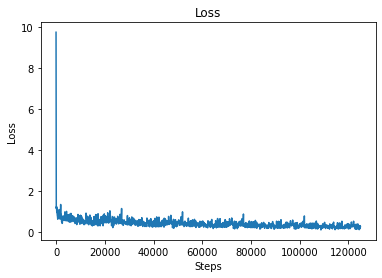

In [ ]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

## save the model

In [ ]:
torch.save(model.state_dict(),'/content/t5_en_model.h5')
#model1 = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#model1.load_state_dict(torch.load('/content/t5_en_model.h5'))


In [ ]:
torch.save(model.state_dict(),'t5_en_pytoch_model.bin')

## downloading the config file

In [ ]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

--2022-08-17 05:04:00--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.233.48
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.233.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2022-08-17 05:04:00 (77.3 MB/s) - ‘t5-base-config.json’ saved [1199/1199]



## load the model and inference

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('/content/t5_en_pytoch_model.bin', return_dict=True,config='/content/t5-base-config.json')

In [ ]:
def generate(text):
  model.eval()
  input_ids = tokenizer.encode("generate:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  # input_ids.to(dev)
  s = time.time()
  outputs = model.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

In [ ]:
generate('hari | treatment')

Generated in 1.23 seconds


' I have a treatment that looks like ahari -like treatment.'

## ref 
https://github.com/MathewAlexander/T5_nlg/blob/main/T5_data_to_text.ipynb

In [ ]:
## model quantization
import torch.quantization
import torch.nn as nn

quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear,nn.Dropout,nn.LayerNorm}, dtype=torch.qint8
)



def quant_generate(text):
  quantized_model.eval()
  input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  # input_ids.to(dev)
  s = time.time()
  outputs = quantized_model.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

In [ ]:
## model quantization
import torch.quantization
import torch.nn as nn

quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear,nn.Dropout,nn.LayerNorm}, dtype=torch.qint8
)

torch.save(quantized_model.state_dict(), "/content/t5_en_quantized_pytoch_model.bin")